In [1]:
import pandas as pd
from  pandasql import sqldf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import datetime

In [2]:
df_train = pd.read_csv('train.csv')
df_hist_trans = pd.read_csv('historical_transactions.csv')
df_new_merchant_trans = pd.read_csv('new_merchant_transactions.csv')
df_merchant= pd.read_csv('merchants.csv')

In [3]:
df_train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [4]:
df_train[df_train['card_id']=='C_ID_92a2005557']

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283


### Replacing missing values


In [5]:
df_train.shape

(201917, 6)

In [6]:
for i in [df_train,df_hist_trans,df_new_merchant_trans,df_merchant]:
    print(i.shape)
    print(i.isnull().sum())
    print()

(201917, 6)
first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
dtype: int64

(29112361, 14)
authorized_flag               0
card_id                       0
city_id                       0
category_1                    0
installments                  0
category_3               178159
merchant_category_id          0
merchant_id              138481
month_lag                     0
purchase_amount               0
purchase_date                 0
category_2              2652864
state_id                      0
subsector_id                  0
dtype: int64

(1963031, 14)
authorized_flag              0
card_id                      0
city_id                      0
category_1                   0
installments                 0
category_3               55922
merchant_category_id         0
merchant_id              26216
month_lag                    0
purchase_amount              0
purchase_date                

In [7]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df.category_2.fillna(df_hist_trans.category_2.mode()[0],inplace=True)
    df.category_3.fillna(df_hist_trans.category_3.mode()[0],inplace=True)
    df.merchant_id.fillna(df_hist_trans.merchant_id.mode()[0],inplace=True)

In [8]:
df_merchant.category_2.fillna(df_merchant.category_2.mode()[0],inplace=True)
df_merchant.avg_sales_lag12.fillna(df_merchant.avg_sales_lag12.mode()[0],inplace=True)
df_merchant.avg_sales_lag6.fillna(df_merchant.avg_sales_lag6.mode()[0],inplace=True)
df_merchant.avg_sales_lag3.fillna(df_merchant.avg_sales_lag3.mode()[0],inplace=True)

### Convert Str to Date

In [9]:
df_train['first_active_month'] = pd.to_datetime(df_train['first_active_month'])
df_new_merchant_trans['purchase_date'] = pd.to_datetime(df_new_merchant_trans['purchase_date'])
df_hist_trans['purchase_date'] = pd.to_datetime(df_hist_trans['purchase_date'])

### Convert Categorical values to Numerical (or Binary)


In [10]:
df_new_merchant_trans.category_1.value_counts()

N    1899935
Y      63096
Name: category_1, dtype: int64

In [11]:
def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

df_new_merchant_trans=binarize(df_new_merchant_trans)
df_hist_trans=binarize(df_hist_trans)

In [12]:
def binarize(df):
    for col in ['category_4', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

df_merchant=binarize(df_merchant)

In [13]:
df_new_merchant_trans.category_3.value_counts()

A    978166
B    836178
C    148687
Name: category_3, dtype: int64

In [14]:
def cat_to_num(df):
    df['category_3'] = df['category_3'].map({'A':1, 'B':2,'C':3})
    return df

df_new_merchant_trans=cat_to_num(df_new_merchant_trans)
df_hist_trans=cat_to_num(df_hist_trans)

In [15]:
df_merchant.most_recent_sales_range.value_counts()

E    177104
D    117475
C     34075
B      5037
A      1005
Name: most_recent_sales_range, dtype: int64

In [16]:
def cat_to_num(df):
    df['most_recent_sales_range'] = df['most_recent_sales_range'].map({'A':1, 'B':2,'C':3,'D':4,'E':5})
    df['most_recent_purchases_range'] = df['most_recent_purchases_range'].map({'A':1, 'B':2,'C':3,'D':4,'E':5})
    return df

df_merchant=cat_to_num(df_merchant)

In [17]:
df=pd.concat([df_hist_trans, df_new_merchant_trans], ignore_index=True, axis=0)

In [18]:
df.head(5)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_4e6213e9bc,88,0,0,1,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,1,C_ID_4e6213e9bc,88,0,0,1,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,1,C_ID_4e6213e9bc,88,0,0,1,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,1,C_ID_4e6213e9bc,88,0,0,1,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,1,C_ID_4e6213e9bc,88,0,0,1,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


### Reduce Storage 

In [19]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [20]:
for i in [df_train,df_hist_trans,df_new_merchant_trans,df_merchant,df]:
    reduce_mem_usage(i)

Mem. usage decreased to  4.04 Mb (56.2% reduction)
Mem. usage decreased to 1166.08 Mb (62.5% reduction)
Mem. usage decreased to 74.88 Mb (64.3% reduction)
Mem. usage decreased to 21.39 Mb (61.9% reduction)
Mem. usage decreased to 1244.70 Mb (62.5% reduction)


### Removing Test dataset user from train dataset


In [21]:
df=df[df.card_id.isin(df_train.card_id)]

In [22]:
df_test=pd.read_csv('test.csv')

In [23]:
df=pd.merge(df, df_train, how='left', on='card_id', suffixes=('_x', '_y'))

In [24]:
len(df.card_id.unique()),len(df_train.card_id.unique())

(201917, 201917)

### EDA

<Axes: xlabel='category_1', ylabel='count'>

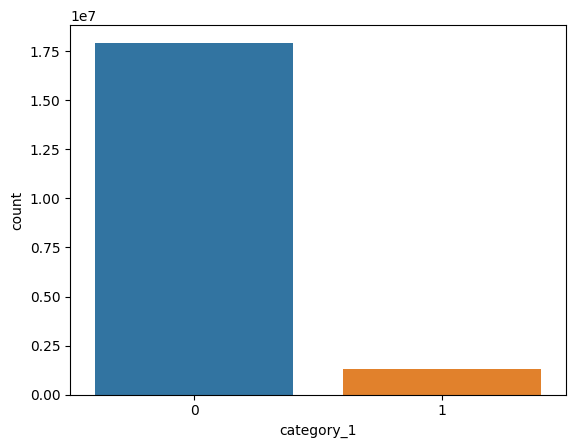

In [40]:
sns.countplot(data=df, x="category_1")

<Axes: xlabel='category_2', ylabel='count'>

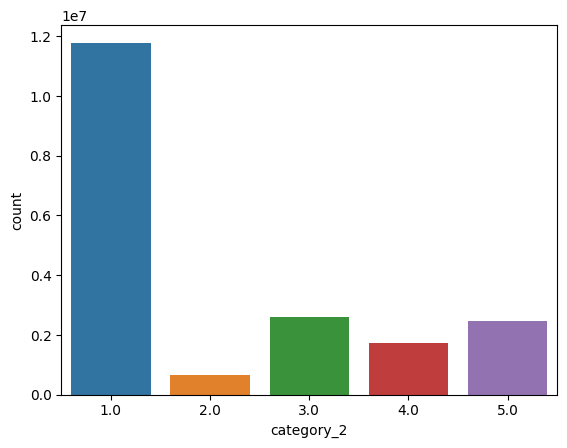

In [41]:
sns.countplot(data=df, x="category_2")

<Axes: xlabel='category_3', ylabel='count'>

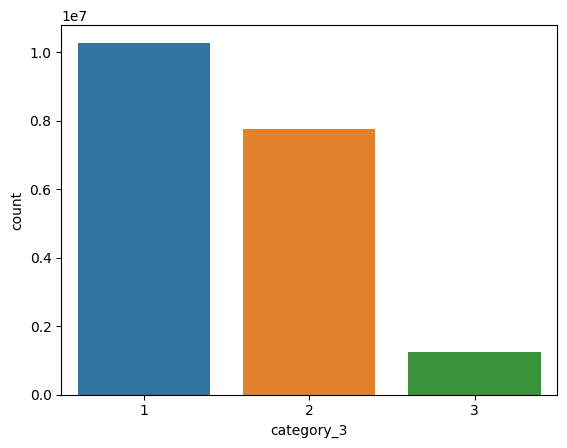

In [42]:
sns.countplot(data=df, x="category_3")

<Axes: xlabel='authorized_flag', ylabel='count'>

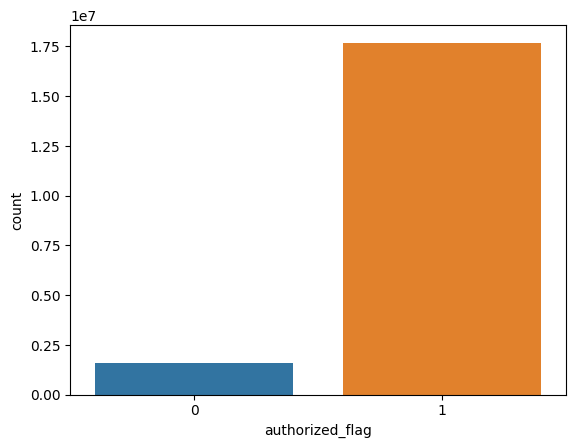

In [45]:
sns.countplot(data=df, x="authorized_flag")

C:\Users\raypr\AppData\Local\Temp\ipykernel_14412\2764648758.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),  linewidths=.5)


<Axes: >

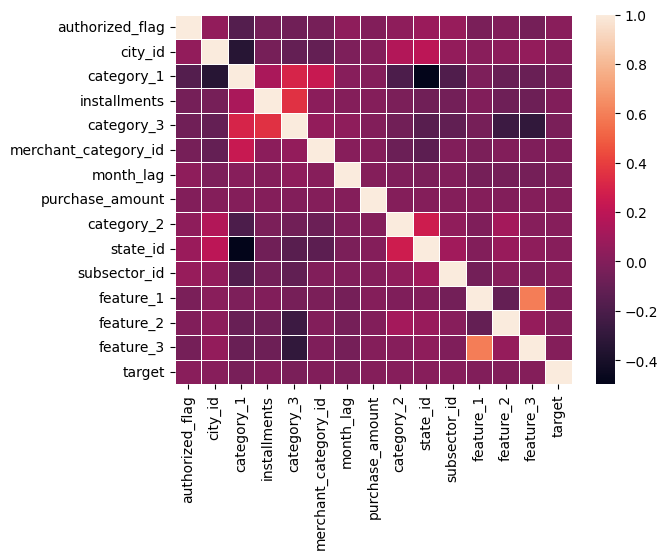

In [25]:
sns.heatmap(df.corr(),  linewidths=.5)

### Feature Engineering

In [26]:
aggs = {}

aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['authorized_flag'] = ['sum', 'mean','median']
aggs['category_1'] = ['sum', 'mean','median']
aggs['card_id'] = ['size']
aggs['category_3'] = ['sum', 'mean','median']
aggs['category_2'] = ['sum', 'mean','median']

new_columns =[ i + '_' + val for i in aggs.keys() for val in aggs[i]]

In [27]:
df_train_new=df.groupby(['card_id']).agg(aggs)

In [28]:
df_train_new.columns = new_columns
df_train_new=df_train_new.reset_index()

In [29]:
max_date =pd.to_datetime(max(df['purchase_date']))
max_date

Timestamp('2018-04-30 23:59:59')

In [30]:
df_train_new['purchase_date_max']=pd.to_datetime(df_train_new['purchase_date_max'])

In [31]:
df_train_new['Recency'] = df_train_new['purchase_date_max'].apply(lambda x:(max_date-x).days)

In [32]:
df_train_new['AOV']=df_train_new['purchase_amount_sum']/df_train_new['card_id_size']

In [33]:
df_train_new['Predictive_CLV'] = df_train_new['AOV']*df_train_new['card_id_size']*df_train_new['purchase_amount_sum'] 

In [34]:
df_train_new=df_train_new.merge(df_train,on='card_id')

In [35]:
df_train_new['first_active_month'].max()

Timestamp('2018-02-01 00:00:00')

In [36]:
df_train_new['first_active_month']=pd.to_datetime(df_train_new['first_active_month'])

In [37]:
df_train_new['elapsed_time'] = (datetime.date(2018, 2, 1) - df_train_new['first_active_month'].dt.date).dt.days

In [38]:
df_train_new.shape

(201917, 39)

C:\Users\raypr\AppData\Local\Temp\ipykernel_14412\4243437874.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmax = df_train_new.corr()


<Axes: >

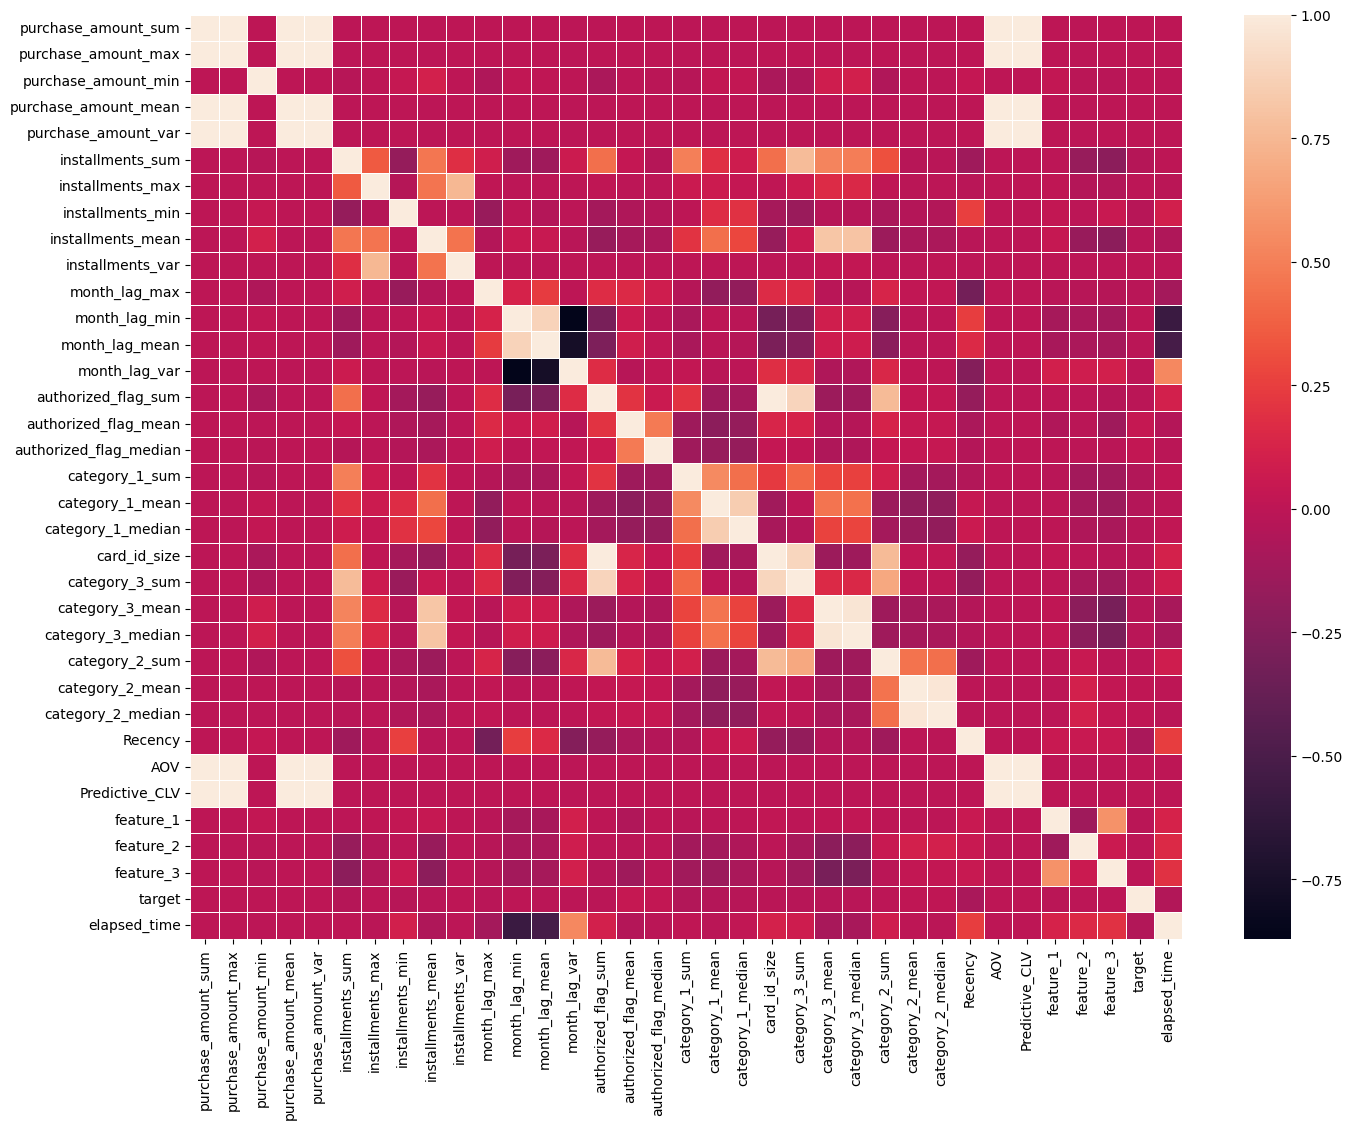

In [39]:
corrmax = df_train_new.corr()

f, ax = plt.subplots(figsize=(16,12))
sns.heatmap(corrmax,  linewidths=.5)

<Axes: xlabel='target'>

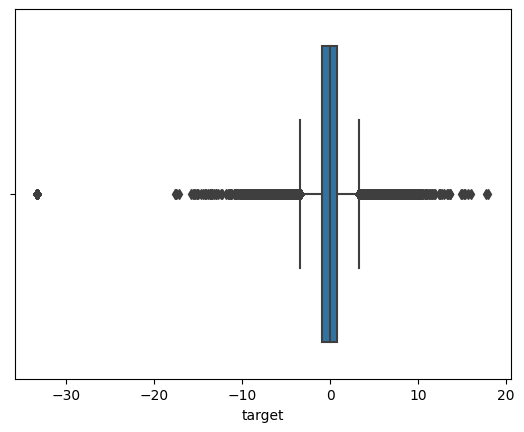

In [49]:
sns.boxplot(x=df_train_new['target'])

### Removing Outliers

In [50]:
def remove_outlier(data,column):
    q1=np.percentile(data[column], 25)
    q3=np.percentile(data[column], 75)

    lower_bound=q1-1.5*(q3-q1)
    upper_bound=q3+1.5*(q3-q1)
    
    data=data[(data[column]<upper_bound) & (data[column]>lower_bound)]
    
    return data

In [51]:
df_train_new=remove_outlier(df_train_new,'target')
df_train_new=remove_outlier(df_train_new,'purchase_amount_sum')

In [52]:
df_train_new.shape

(171633, 39)

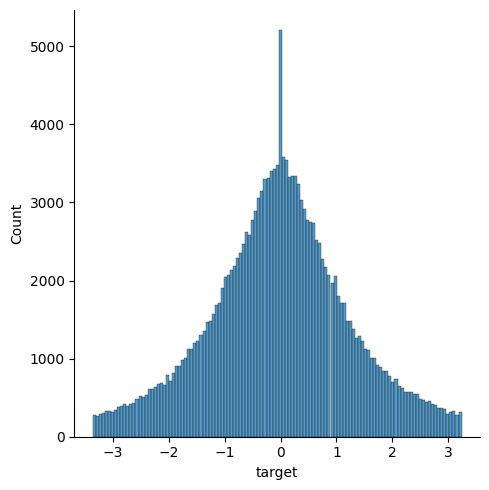

In [56]:
sns.displot(df_train_new, x="target")

### Standardization

In [57]:
scaler = StandardScaler()
data=df_train_new.loc[:,~df_train_new.columns.isin(['card_id','first_active_month','purchase_date_max','purchase_date_min'])]
scaled=scaler.fit_transform(data)

X=pd.DataFrame(scaled,columns=data.columns)

In [59]:
temp=X.loc[:,~X.columns.isin(['target','card_id','first_active_month','purchase_date_max','purchase_date_min'])]

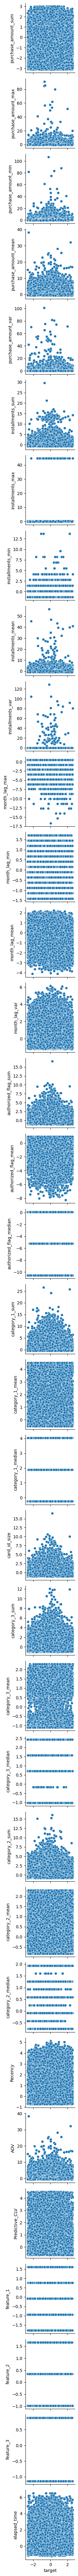

In [60]:
sns.pairplot(data=X,x_vars=['target'],y_vars=temp.columns)

In [61]:
from sklearn.impute import SimpleImputer
my_imputer = SimpleImputer()

In [62]:
y = X['target']

X =X.loc[:,~X.columns.isin(['target','card_id','first_active_month','purchase_date_max','purchase_date_min'])]

X = my_imputer.fit_transform(X)

### Training Model

In [78]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=6)

In [79]:
from sklearn.ensemble import RandomForestRegressor

reg_predictions = []

In [80]:
myRandomForestReg = RandomForestRegressor(n_estimators = 9, bootstrap = True, random_state = 3)

myRandomForestReg.fit(X_train, y_train)

y_predict_myRandomForestReg = myRandomForestReg.predict(X_test)

reg_predictions.append(y_predict_myRandomForestReg)

In [81]:
from sklearn import metrics

for model, y_prediction in zip([ 'Random Forest: '], reg_predictions):
    mse = metrics.mean_squared_error(y_test, y_prediction)
    rmse = np.sqrt(mse)
    print(model + str(rmse))

Random Forest: 1.0334911670925102


### XGB

In [75]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error

In [72]:
model = XGBRegressor()

In [73]:
model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [76]:
xgb_model =XGBRegressor(objective="reg:linear", random_state=42)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

mse=mean_squared_error(y_test, y_pred)

print(np.sqrt(mse))

[15:35:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
0.9766858556897553
